# Parallel Bifurcation Map

Each process is assigned a range of parameter values, and the results are gathered at the master node. The bifurcation map shows the stable values of the logistic map for different parameter values, and parallelization is achieved by distributing the parameter range among different processes.

In [1]:
!pip install mpi4py

In [2]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (14,7)
plt.rcParams["font.size"] = 14

In [3]:
%%writefile parallel_bifurcation_map.py

# Import necessary libraries
import numpy as np
from mpi4py import MPI

# Initialize MPI communication
comm = MPI.COMM_WORLD
size = comm.Get_size()  # Get the total number of processes
rank = comm.Get_rank()  # Get the rank of the current process

# Parameters for the logistic map
m = 100
N = 1000
x0 = 0.04
perrank = N // size  # Number of points to be computed by each process

# Logistic map function
def logistic_map(r, x):
    return r * x * (1 - x)

# Function to save the last m values of the logistic map
def SaveX(r, x0, m):
    x = np.zeros(N)
    x[0] = x0

    for n in range(1, N):
        x[n] = logistic_map(r, x[n-1])
    return x[-m:]

# Function to compute bifurcation map for a range of parameter values
def bifurcation_map(m, N, x0, rank):
    r_full = np.linspace(0, 4.0, N)
    r = r_full[perrank * rank : perrank * (rank + 1)]  # Divide parameter range among processes
    if rank == (size - 1):
        r = r_full[perrank * rank:]  # Handle the last process to include remaining values

    x = np.zeros((len(r), m))

    for i, r_i in enumerate(r):
        x[i, :] = SaveX(r_i, x0, m)  # Compute the logistic map for each parameter value

    return r, x

# Start timing
start = MPI.Wtime()

# Compute bifurcation map for the current process
r, x = bifurcation_map(m, N, x0, rank)

# Gather the results at the master node
r, x = comm.gather(x, root=0), comm.gather(r, root=0)

# End timing
end = MPI.Wtime()

# Print the total time taken by the master node
if rank == 0:
    print(end - start)


Overwriting parallel_bifurcation_map.py


#### We can run mpiexec on Colab only by adding the flags `--allow-run-as-root` and `--oversubscribe`... Thus, our output here will not reflect the correct results due to unreal parallelism.

In [4]:
!mpiexec -n 4 python parallel_bifurcation_map.py

--------------------------------------------------------------------------
mpiexec has detected an attempt to run as root.

Running as root is *strongly* discouraged as any mistake (e.g., in
defining TMPDIR) or bug can result in catastrophic damage to the OS
file system, leaving your system in an unusable state.

We strongly suggest that you run mpiexec as a non-root user.

You can override this protection by adding the --allow-run-as-root option
to the cmd line or by setting two environment variables in the following way:
the variable OMPI_ALLOW_RUN_AS_ROOT=1 to indicate the desire to override this
protection, and OMPI_ALLOW_RUN_AS_ROOT_CONFIRM=1 to confirm the choice and
add one more layer of certainty that you want to do so.
We reiterate our advice against doing so - please proceed at your own risk.
--------------------------------------------------------------------------


In [5]:
!mpiexec -n 4 --allow-run-as-root python parallel_bifurcation_map.py

--------------------------------------------------------------------------
There are not enough slots available in the system to satisfy the 4
slots that were requested by the application:

  python

Either request fewer slots for your application, or make more slots
available for use.

A "slot" is the Open MPI term for an allocatable unit where we can
launch a process.  The number of slots available are defined by the
environment in which Open MPI processes are run:

  1. Hostfile, via "slots=N" clauses (N defaults to number of
     processor cores if not provided)
  2. The --host command line parameter, via a ":N" suffix on the
     hostname (N defaults to 1 if not provided)
  3. Resource manager (e.g., SLURM, PBS/Torque, LSF, etc.)
  4. If none of a hostfile, the --host command line parameter, or an
     RM is present, Open MPI defaults to the number of processor cores

In all the above cases, if you want Open MPI to default to the number
of hardware threads instead of the number of

In [6]:
!mpiexec -n 4 --allow-run-as-root --oversubscribe python parallel_bifurcation_map.py

0.842494265


Now it works!

In [7]:
execution_time = []
N_processes = [1, 2, 4, 8, 16, 32, 64]
for i in N_processes:
    print(f"{i} Processes started... ", end="")
    add = !mpiexec -n {i} --allow-run-as-root --oversubscribe python parallel_bifurcation_map.py
    execution_time.append(float(add[0]))
    print(f"done in {add[0]}s.")


1 Processes started... done in 1.188613103s.
2 Processes started... done in 1.074032153s.
4 Processes started... done in 0.748262208s.
8 Processes started... done in 0.791804532s.
16 Processes started... done in 1.317521144s.
32 Processes started... done in 0.7094189719999999s.
64 Processes started... done in 2.431058108s.


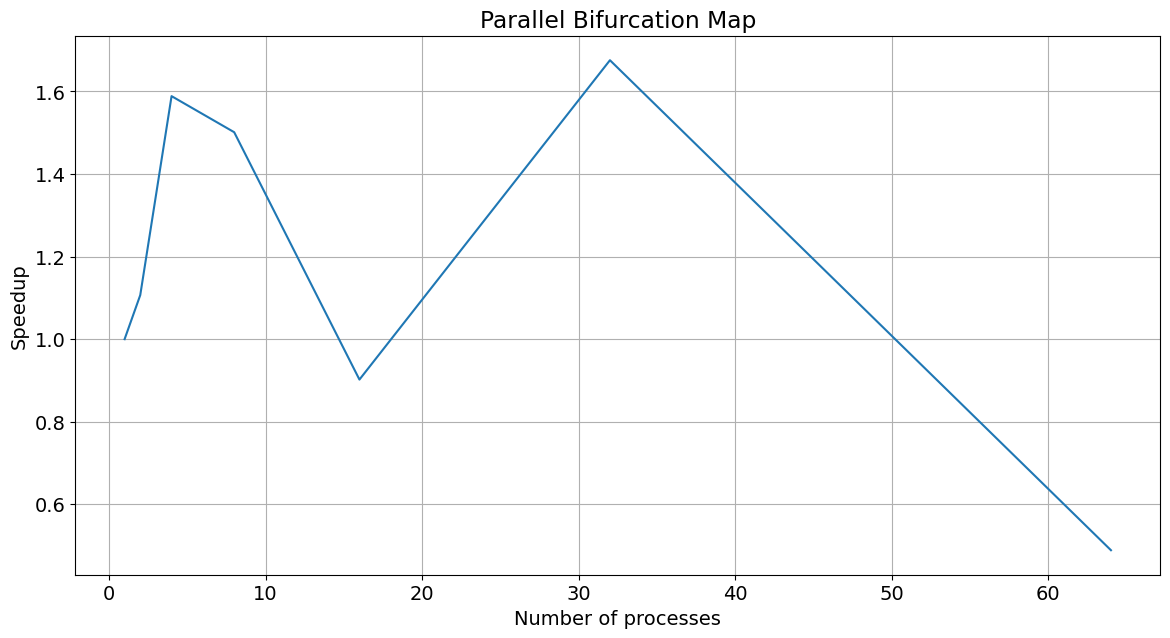

In [8]:
plt.plot(N_processes,  execution_time[0] / np.array(execution_time))
plt.title('Parallel Bifurcation Map')
plt.xlabel('Number of processes')
plt.ylabel('Speedup')
plt.grid(True)

# Parallel Spectrogram

The spectrogram is calculated by applying a Fourier transform to different windows of the signal. Each process is assigned a range of window positions, and the results are gathered at the master node.

In [9]:
%%writefile parallel_spectrogram.py

# Import necessary libraries
import numpy as np
from mpi4py import MPI

# Initialize MPI communication
comm = MPI.COMM_WORLD
size = comm.Get_size()  # Get the total number of processes
rank = comm.Get_rank()  # Get the rank of the current process

# Generate the signal composed of multiple sinusoidal waves
t = np.linspace(-20 * 2 * np.pi, 20 * 2 * np.pi, 3**9 + 6)
y = np.sin(t) * np.exp(-t**2 / 2 / 20**2)
y += np.sin(3 * t) * np.exp(-(t - 5 * 2 * np.pi)**2 / 2 / 20**2)
y += np.sin(5.5 * t) * np.exp(-(t + 10 * 2 * np.pi)**2 / 2 / 5**2)
y += np.sin(4 * t) * np.exp(-(t - 7 * 2 * np.pi)**2 / 2 / 10**2)  # Added 4th wave packet

# Function to compute the spectrogram in parallel
def get_specgram(y, t, nwindowsteps=1000):
  perrank = nwindowsteps // size
  window_t_full = np.linspace(-20 * 2 * np.pi, 20 * 2 * np.pi, nwindowsteps)
  window_t = window_t_full[perrank * rank:perrank * (rank + 1)]

  if rank == (size - 1):
    window_t = window_t_full[perrank * rank:]

  specgram = np.zeros((len(t), nwindowsteps))
  window_width = 2.0 * 2 * np.pi

  # Compute the spectrogram using the Fourier transform for each window
  for n, w_t in enumerate(window_t):
    window_function = np.exp(-(t - w_t)**2 / 2 / window_width**2)
    specgram[:, n] = abs(np.fft.fft(y * window_function))

  return specgram

# Start timing
start = MPI.Wtime()

# Compute the spectrogram for the current process
specgram = get_specgram(y, t, 1000)

# Gather the results at the master node
specgram = comm.gather(specgram, root=0)

# End timing
end = MPI.Wtime()

# Print the total time taken by the master node
if rank == 0:
  print(end - start)

Overwriting parallel_spectrogram.py


In [10]:
execution_time = []
N_processes = [1, 2, 4, 8, 12]
for i in N_processes:
  print(f"{i} Processes started... ", end="")
  add = !mpiexec -n {i} --allow-run-as-root --oversubscribe python parallel_spectrogram.py
  execution_time.append(float(add[0]))
  print(f"done in {add[0]}s.")

1 Processes started... done in 20.39742617s.
2 Processes started... done in 6.064496024s.
4 Processes started... done in 9.072729734s.
8 Processes started... done in 14.295399665s.
12 Processes started... done in 17.945313991s.


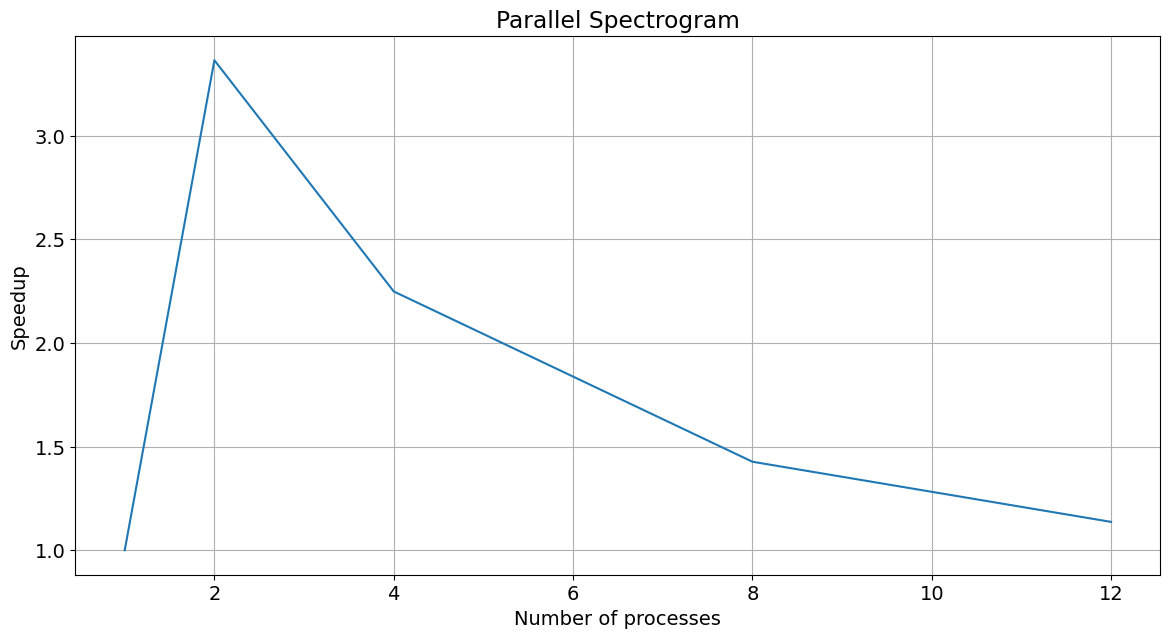

In [11]:
plt.plot(N_processes, execution_time[0] / np.array(execution_time))
plt.title('Parallel Spectrogram')
plt.xlabel('Number of processes')
plt.ylabel('Speedup')
plt.grid(True)